In [1]:
# !pip install gurobipy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
# %matplotlib inline

In [3]:
# from google.colab import drive 
# drive.mount('/content/drive')

In [4]:
#price and demand given 
#demand is impacted by price : D = beta0 + beta1*Price + errori 
# demand = pd.read_csv('/content/drive/My Drive/Grad/Spring/Opti_2/Project1/price_demand_data.csv')
demand = pd.read_csv('price_demand_data.csv')
demand

,price,demand
0,1.05,283
1,0.86,771
2,1.21,185
3,0.94,531
4,0.76,1002
...,...,...
94,1.13,321
95,0.78,970
96,1.04,387
97,1.02,831


## Question 1

In [5]:
#beta0 and betai
y = demand['demand'].values.reshape(-1, 1)
x = demand['price'].values.reshape(-1, 1)
model = LinearRegression().fit(x,y)
prediction = model.predict(x)
residual = (y - prediction)
demand['residual'] = residual
print('Intercept: ', model.intercept_[0])
print('Coefficient: ', model.coef_[0][0])
demand

Intercept:  1924.7175435291088
Coefficient:  -1367.7125241625984


,price,demand,residual
0,1.05,283,-205.619393
1,0.86,771,22.515227
2,1.21,185,-84.785389
3,0.94,531,-108.067771
4,0.76,1002,116.743975
...,...,...,...
94,1.13,321,-58.202391
95,0.78,970,112.098225
96,1.04,387,-115.296518
97,1.02,831,301.349231


## Question 2

In [6]:
new_d = pd.DataFrame()
new_d['demand'] = residual[0:,0].tolist() + model.intercept_[0] + model.coef_[0]
new_d

,demand
0,351.385626
1,579.520247
2,472.219630
3,448.937249
4,673.748994
...,...
94,498.802628
95,669.103245
96,441.708501
97,858.354250


## Question 3

In [7]:
c = 0.5
g = 0.75
t = 0.15
p = 1
nd = demand.shape[0]

# decision variables are (q, h1, h2, ..., h99) coeff of q would be 0, h1,h2... would have coeff of 1/99
obj = np.zeros(nd+1)
obj[1:] = 1.0/nd 
ub = np.zeros(nd+1)
ub[0] = np.inf # the h variable can't be positive because it will always be negaitve (cost is always positive thus negative cost is negative)
lb = np.zeros(nd+1)
lb[1:] = -np.inf
rhs = np.zeros(2*nd)
#
direction = np.array(['<']*(2*nd))#hi needs to be less than the -cost (think of h under the two line of cost and we want to maximize hi so that its as close to 0 as possible)

In [8]:
A = np.zeros((2*nd,nd+1))#99*2 rows + 100 cols
for r in range(nd):
  #the constraint when P >= Di
  A[2*r,[0,r+1]] = [c-g,1] 
  rhs[2*r] = -g*new_d.demand[r]
  #constraint when P <= Di
  A[2*r+1,[0,r+1]] = [c+t,1]
  rhs[2*r+1] = t*new_d.demand[r]

In [9]:
spMod = gp.Model()
spMod_x = spMod.addMVar(len(obj),lb=lb,ub=ub) # tell the model how many variables there are
# must define the variables before adding constraints because variables go into the constraints
spMod_con = spMod.addMConstrs(A, spMod_x, direction, rhs) # NAME THE CONSTRAINTS!!! so we can get information about them later!
spMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0

spMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
spMod.optimize()

Academic license - for non-commercial use only - expires 2022-09-15
Using license file C:\Users\User\gurobi.lic


In [10]:
#optimal quantity 
spMod_x.x[0]

471.8653795908935

In [11]:
#cost: negative because we are maximizing negative hi, can switch direction and sign and then minimize to get positive cost
spMod.objval

-325.5213527193693

### Bootstrapping and Plots

In [12]:
def gurobi_fit_price1(data):
  c = 0.5
  g = 0.75
  t = 0.15
  p = 1
  nd = data.shape[0]

  
  obj = np.zeros(nd+1)
  obj[1:] = 1.0/nd 
  ub = np.zeros(nd+1)
  ub[0] = np.inf 
  lb = np.zeros(nd+1)
  lb[1:] = -np.inf
  rhs = np.zeros(2*nd)
  direction = np.array(['<']*(2*nd))

  A = np.zeros((2*nd,nd+1))
  for r in range(nd):
    #the constraint when P >= Di
    A[2*r,[0,r+1]] = [c-g,1] 
    rhs[2*r] = -g*data.demand[r]
    #constraint when P <= Di
    A[2*r+1,[0,r+1]] = [c+t,1]
    rhs[2*r+1] = t*data.demand[r]

  spMod = gp.Model()
  spMod_x = spMod.addMVar(len(obj),lb=lb,ub=ub) 
  spMod_con = spMod.addMConstrs(A, spMod_x, direction, rhs) 
  spMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)

  spMod.Params.OutputFlag = 0 
  spMod.optimize()

  quantity = spMod_x.x[0]
  profit = spMod.objval
  return quantity,profit

In [13]:
#simulation for the p=1 model 
quantity_p = []
profit_p = []
sim = 1000

for i in range(sim):
  samp = new_d.sample(n=new_d.shape[0],replace=True)
  samp.reset_index(inplace=True)
  new_q,new_pro = gurobi_fit_price1(samp)
  quantity_p.append(new_q)
  profit_p.append(new_pro)

C:\Users\User\AppData\Local\Temp\ipykernel_4872\1942805963.py:9: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  new_q,new_pro = gurobi_fit_price1(samp)


In [14]:
result_p = pd.DataFrame()
result_p['quantity'] = quantity_p
result_p['profit'] = profit_p
result_p

,quantity,profit
0,480.874497,-329.023632
1,453.134620,-321.608098
2,478.573881,-321.147651
3,467.417002,-323.973709
4,448.937249,-322.463989
...,...,...
995,472.219630,-318.063812
996,438.708501,-311.120436
997,453.134620,-333.227597
998,495.291499,-331.570237


Text(0, 0.5, 'Frequency')

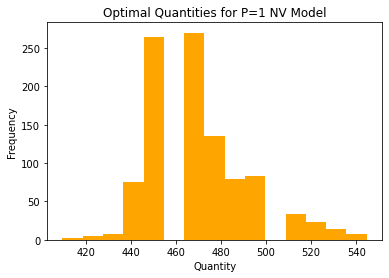

In [15]:
#plotting histogram for quantity 
result_p.hist(column='quantity',grid=False, bins = 15, color = 'orange')
plt.title("Optimal Quantities for P=1 NV Model")
plt.xlabel('Quantity')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

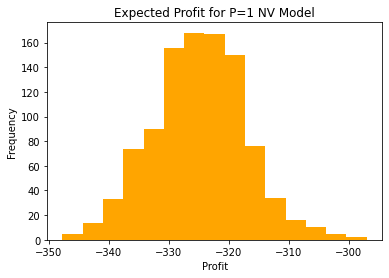

In [16]:
#plotting histogram for profit 
result_p.hist(column='profit',grid=False, bins = 15, color = 'orange')
plt.title("Expected Profit for P=1 NV Model")
plt.xlabel('Profit')
plt.ylabel('Frequency')

## Question 4

In [17]:
#Creating a new demand df for Di with intercept + residual 
demand_q = pd.DataFrame()
demand_q['demand'] = residual[0:,0].tolist() + model.intercept_[0] 
demand_q

,demand
0,1719.098150
1,1947.232771
2,1839.932154
3,1816.649773
4,2041.461518
...,...
94,1866.515152
95,2036.815769
96,1809.421025
97,2226.066775


In [18]:
#creating the Q matrix 
#this takes care of the quadratic in the objective function 
Q = np.zeros((101,101))
Q[0][0] = model.coef_[0][0]
Q

array([[-1367.71252416,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ]])

In [19]:
#Linear part 
c = 0.5
g = 0.75
t = 0.15
nd = demand_q.shape[0]

# decision variables are (p,q, h1, h2, ..., h99) coeff of p would be Di (mean(residual)+intercept)
#obj is the revenue + cost, revenue represented by pDi
obj = np.zeros(nd+2)
obj[0] = np.mean(residual[0:,0].tolist()) + model.intercept_[0] 
obj[2:] = 1.0/nd 
ub = np.zeros(nd+2)
ub[:2] = np.inf #p will be positive
lb = np.zeros(nd+2)
lb[2:] = -np.inf
rhs = np.zeros(2*nd)
direction = np.array(['<']*(2*nd))

In [20]:
A = np.zeros((2*nd,nd+2))#99*2 rows + 101 cols
for r in range(nd):
  #the constraint when P >= Di
  A[2*r,[0,1,r+2]] = [g*model.coef_[0][0],c-g,1] #for p, the coefficient beta1 and g is present after substituting in the function for Di
  rhs[2*r] = -g*demand_q.demand[r]
  #constraint when P <= Di
  A[2*r+1,[0,1,r+2]] = [-t*model.coef_[0][0],c+t,1]
  rhs[2*r+1] = t*demand_q.demand[r]

In [21]:
spMod = gp.Model()
spMod_x = spMod.addMVar(len(obj),lb=lb,ub=ub) # tell the model how many variables there are
# must define the variables before adding constraints because variables go into the constraints
spMod_con = spMod.addMConstrs(A, spMod_x, direction, rhs) # NAME THE CONSTRAINTS!!! so we can get information about them later!
spMod.setMObjective(Q,obj,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0

spMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
spMod.optimize()

In [22]:
#optimal price and quantity 
spMod_x.x[0],spMod_x.x[1] 

(0.9536264966228529, 535.2910009500025)

In [23]:
#objective value: expected profit
spMod.objval

234.42493491247865

## Question 6

In [24]:
#generating a bootstrap sample of demand
boot_samp = demand.sample(n=nd,replace=True) # take a random sample of demand each iteration
boot_samp.iloc[:,:2]

,price,demand
49,1.11,389
27,0.91,423
68,0.97,585
2,1.21,185
7,0.88,645
...,...,...
31,0.90,476
67,1.23,164
69,1.20,341
68,0.97,585


In [25]:
#fitting new regression
y2 = boot_samp['demand'].values.reshape(-1, 1)
x2 = boot_samp['price'].values.reshape(-1, 1)
model2 = LinearRegression().fit(x2,y2)
prediction2 = model2.predict(x2)
residual2 = (y2 - prediction2)
boot_samp['residual'] = residual2
print('Intercept: ', model2.intercept_[0])
print('Coefficient: ', model2.coef_[0][0])
boot_samp

Intercept:  2000.5908696960955
Coefficient:  -1444.4005998594018


,price,demand,residual
49,1.11,389,-8.306204
27,0.91,423,-263.186324
68,0.97,585,-14.522288
2,1.21,185,-67.866144
7,0.88,645,-84.518342
...,...,...,...
31,0.90,476,-224.630330
67,1.23,164,-59.978132
69,1.20,341,73.689850
68,0.97,585,-14.522288


In [26]:
#Recreating Question 4

#Creating a new demand df for Di with intercept + residual 
boot_q = pd.DataFrame()
boot_q['demand'] = residual2[0:,0].tolist() + model2.intercept_[0] 

#creating the Q matrix 
Q2 = np.zeros((101,101))
Q2[0][0] = model2.coef_[0][0]

#Linear part 
c = 0.5
g = 0.75
t = 0.15
nd = boot_q.shape[0]

obj = np.zeros(nd+2)
obj[0] = np.mean(residual2[0:,0].tolist()) + model2.intercept_[0] 
obj[2:] = 1.0/nd 
ub = np.zeros(nd+2)
ub[:2] = np.inf #p will be positive
lb = np.zeros(nd+2)
lb[2:] = -np.inf
rhs = np.zeros(2*nd)
direction = np.array(['<']*(2*nd))

#Creating constraints
A = np.zeros((2*nd,nd+2))#99*2 rows + 101 cols
for r in range(nd):
  #the constraint when P >= Di
  A[2*r,[0,1,r+2]] = [g*model2.coef_[0][0],c-g,1] #for p, the coefficient beta1 and g is present after substituting in the function for Di
  rhs[2*r] = -g*boot_q.demand[r]
  #constraint when P <= Di
  A[2*r+1,[0,1,r+2]] = [-t*model2.coef_[0][0],c+t,1]
  rhs[2*r+1] = t*boot_q.demand[r]

spMod = gp.Model()
spMod_x = spMod.addMVar(len(obj),lb=lb,ub=ub)
spMod_con = spMod.addMConstrs(A, spMod_x, direction, rhs) 
spMod.setMObjective(Q2,obj,0,sense=gp.GRB.MAXIMIZE) 

spMod.Params.OutputFlag = 0 
spMod.optimize()

In [27]:
#optimal price and quantity 
spMod_x.x[0],spMod_x.x[1] 

(0.9425332452346348, 569.4411290283039)

In [28]:
#profit
spMod.objval

231.9491027398144

## Question 7

In [29]:
#make function for fitting model and the gurobi process

def fit_model(data):
  y = data['demand'].values.reshape(-1, 1)
  x = data['price'].values.reshape(-1, 1)
  model = LinearRegression().fit(x,y)
  prediction = model.predict(x)
  residual = (y - prediction)
  data2 = data.copy()
  data2['residual'] = residual

  return model,data2

def gurobi_fit(data,model):

  boot_q = pd.DataFrame()
  boot_q['demand'] = data['residual'] + model.intercept_[0] 
  boot_q.reset_index(inplace = True)
  
  Q2 = np.zeros((101,101))
  Q2[0][0] = model.coef_[0][0]

  c = 0.5
  g = 0.75
  t = 0.15
  nd = boot_q.shape[0]

  obj = np.zeros(nd+2)
  obj[0] = np.mean(data['residual']) + model.intercept_[0] 
  obj[2:] = 1.0/nd 
  ub = np.zeros(nd+2)
  ub[:2] = np.inf 
  lb = np.zeros(nd+2)
  lb[2:] = -np.inf
  rhs = np.zeros(2*nd)
  direction = np.array(['<']*(2*nd))


  A = np.zeros((2*nd,nd+2))
  for r in range(nd):
    #the constraint when P >= Di
    A[2*r,[0,1,r+2]] = [g*model.coef_[0][0],c-g,1] 
    rhs[2*r] = -g*boot_q.demand[r]
    #constraint when P <= Di
    A[2*r+1,[0,1,r+2]] = [-t*model.coef_[0][0],c+t,1]
    rhs[2*r+1] = t*boot_q.demand[r]

  spMod = gp.Model()
  spMod_x = spMod.addMVar(len(obj),lb=lb,ub=ub)
  spMod_con = spMod.addMConstrs(A, spMod_x, direction, rhs) 
  spMod.setMObjective(Q2,obj,0,sense=gp.GRB.MAXIMIZE) 

  spMod.Params.OutputFlag = 0 
  spMod.optimize()
  
  price,quantity = spMod_x.x[0],spMod_x.x[1] 
  profit = spMod.objval
  return price,quantity,profit

In [ ]:
#stimulation
price_l = []
quantity_l = []
profit_l = []
sim = 1000

for i in range(sim):
  samp = demand.sample(n=demand.shape[0],replace=True)
  new_model,new_data = fit_model(samp)
  new_p,new_q,new_pro = gurobi_fit(new_data,new_model)
  price_l.append(new_p)
  quantity_l.append(new_q)
  profit_l.append(new_pro)

In [31]:
result = pd.DataFrame()
result['price'] = price_l
result['quantity'] = quantity_l
result['profit'] = profit_l
result

,price,quantity,profit
0,0.950588,537.657516,235.845250
1,0.971827,493.915007,238.835242
2,0.970575,496.979372,234.140057
3,0.960903,512.843407,228.959224
4,0.921006,567.693946,219.172458
...,...,...,...
995,0.951549,535.023133,230.589739
996,0.933919,574.461694,229.232715
997,0.952805,554.453483,246.121561
998,0.962682,503.841167,237.476021


Text(0, 0.5, 'Frequency')

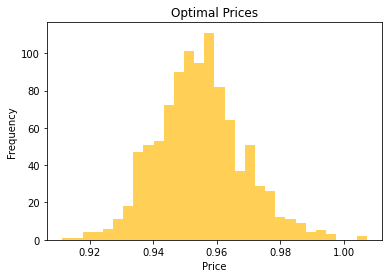

In [32]:
#plotting histogram for price
result.hist(column='price',grid=False,bins=30,color='#FFCF56')
plt.title("Optimal Prices")
plt.xlabel('Price')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

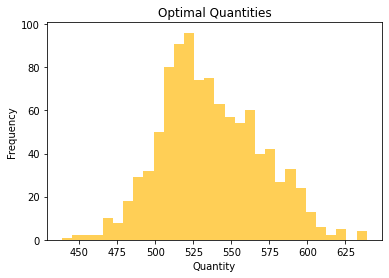

In [33]:
#plotting histogram for quantity 
result.hist(column='quantity',grid=False,bins=30,color='#FFCF56')
plt.title("Optimal Quantities")
plt.xlabel('Quantity')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

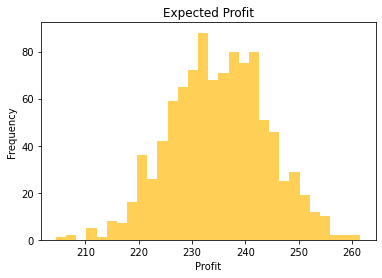

In [34]:
#plotting histogram for profit
result.hist(column='profit',grid=False,bins=30,color='#FFCF56')
plt.title("Expected Profit")
plt.xlabel('Profit')
plt.ylabel('Frequency')

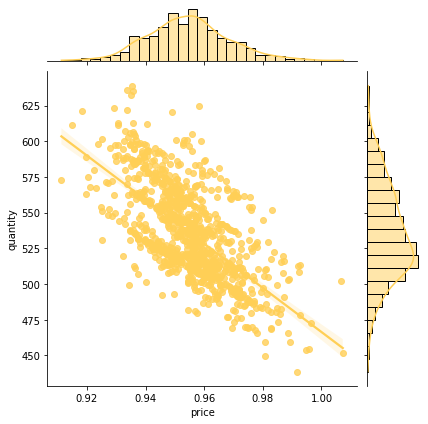

In [35]:
#scatterplot for quantity and price
sns.jointplot(x='price', y='quantity',data=result, kind = 'reg',color = '#FFCF56' )

## Question 8

In [36]:
#creating the standard NV model
c = 0.5
p = 1
nd = demand.shape[0]

# decision variables are (q, h1, h2, ..., h99) coeff of q would be 0, h1,h2... would have coeff of 1/99
obj = np.zeros(nd+1)
obj[1:] = 1.0/nd 
lb = np.zeros(nd+1)
lb[1:] = -np.inf
rhs = np.zeros(2*nd)
direction = np.array(['<']*(2*nd))

In [37]:
A = np.zeros((2*nd,nd+1))
for r in range(nd):
    A[2*r,[0,r+1]] = [c,1] 
    rhs[2*r] = p*new_d.demand[r] 
    A[2*r+1,[0,r+1]] = [c-p,1]#this is the hi + (c-p)q constraint
    rhs[2*r+1] = 0 #rhs of the above constraint is 0 

In [38]:
spMod = gp.Model()
spMod_x = spMod.addMVar(len(obj),lb=lb)
spMod_con = spMod.addMConstrs(A, spMod_x, direction, rhs)
spMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)

spMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
spMod.optimize()

In [39]:
#optimal quantity
spMod_x.x[0]

569.8967553157715

In [40]:
#expected profit 
spMod.objval

219.28316552851413

In [41]:
#doing bootstrapping for the standard model
def gurobi_fit_standard(data):
  c = 0.5
  p = 1
  nd = data.shape[0]

  obj = np.zeros(nd+1)
  obj[1:] = 1.0/nd 
  lb = np.zeros(nd+1)
  lb[1:] = -np.inf
  rhs = np.zeros(2*nd)
  direction = np.array(['<']*(2*nd))

  A = np.zeros((2*nd,nd+1))
  for r in range(nd):
    A[2*r,[0,r+1]] = [c,1] 
    rhs[2*r] = p*data.demand[r] 
    A[2*r+1,[0,r+1]] = [c-p,1]#this is the hi + (c-p)q constraint
    rhs[2*r+1] = 0 #rhs of the above constraint is 0 

  spMod = gp.Model()
  spMod_x = spMod.addMVar(len(obj),lb=lb)
  spMod_con = spMod.addMConstrs(A, spMod_x, direction, rhs)
  spMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)

  spMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
  spMod.optimize()

  quantity = spMod_x.x[0]
  profit = spMod.objval
  return quantity,profit

In [42]:
#simulation for standard model 
quantity_s = []
profit_s = []
sim = 1000

for i in range(sim):
  samp = new_d.sample(n=new_d.shape[0],replace=True)
  samp.reset_index(inplace=True)
  new_q,new_pro = gurobi_fit_standard(samp)
  quantity_s.append(new_q)
  profit_s.append(new_pro)

C:\Users\User\AppData\Local\Temp\ipykernel_4872\2453740169.py:9: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  new_q,new_pro = gurobi_fit_standard(samp)


In [43]:
result_s = pd.DataFrame()
result_s['quantity'] = quantity_s
result_s['profit'] = profit_s
result_s

,quantity,profit
0,569.896755,215.442788
1,597.156879,215.135929
2,561.708501,220.683311
3,554.197372,217.022599
4,552.802628,219.395815
...,...,...
995,593.739877,231.250526
996,569.896755,215.913456
997,551.062751,211.473909
998,579.520247,214.292275


Text(0, 0.5, 'Frequency')

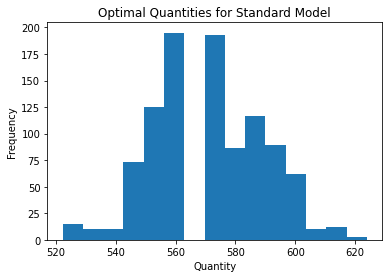

In [44]:
#plotting histogram for quantity for the standard model
result_s.hist(column='quantity',grid=False, bins = 15)
plt.title("Optimal Quantities for Standard Model")
plt.xlabel('Quantity')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

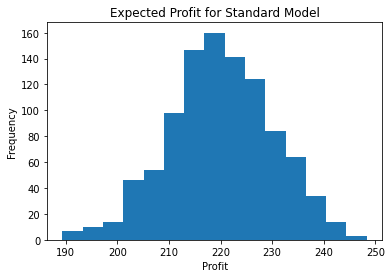

In [45]:
#plotting histogram for profit for the standard model
result_s.hist(column='profit',grid=False, bins = 15)
plt.title("Expected Profit for Standard Model")
plt.xlabel('Profit')
plt.ylabel('Frequency')